<a href="https://www.kaggle.com/code/gpreda/deep-factorization-machine?scriptVersionId=129059173" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

Deep Factorization Machines (DFM) - is a multi-layer neural network to model the user and item latent factors.   

DFM can be trained using backpropagation and can handle missing data.

Source: Factorization Machine models in PyTorch (https://github.com/rixwew/pytorch-fm)


In [1]:
import numpy as np
import pandas as pd
import os
import tqdm
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, mean_squared_error

In [2]:
from movie_lens_data import MovieLensData
from pt_layer import FactorizationMachine, FeaturesEmbedding, FeaturesLinear, MultiLayerPerceptron

# Read the data

In [3]:
path = "/kaggle/input/movielens-100k-dataset/ml-100k"
movie_lens_data = MovieLensData(
    users_path = os.path.join(path, "u.user"),
    ratings_path = os.path.join(path, "u.data"), 
    movies_path = os.path.join(path, "u.item"), 
    genre_path = os.path.join(path, "u.genre") 
    )

evaluation_data = movie_lens_data.read_ratings_data()
movie_data = movie_lens_data.read_movies_data()
popularity_rankings = movie_lens_data.get_popularity_ranks()
ratings = movie_lens_data.get_ratings()

# Prepare the dataset

In [4]:
class MovieLensDataset(torch.utils.data.Dataset):
    """
    MovieLens Dataset
    Data preparation
        treat samples with a rating less than 3 as negative samples
    """
    def __init__(self, ratings):
        data = ratings.copy().to_numpy()
        self.items = data[:, :2].astype(np.int32) - 1  # -1 because ID begins from 1
        self.targets = self.__preprocess_target(data[:, 2]).astype(np.float32)
        self.field_dims = np.max(self.items, axis=0) + 1
        self.user_field_idx = np.array((0, ), dtype=np.int64)
        self.item_field_idx = np.array((1,), dtype=np.int64)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        target = target / 5.
        return target

In [5]:
def get_dataset():
    return MovieLensDataset(ratings)

# Prepare the algorithm

## The model

In [6]:
class DeepFactorizationMachineModel(torch.nn.Module):
    """
    A pytorch implementation of DeepFM.
    Reference:
        H Guo, et al. DeepFM: A Factorization-Machine based Neural Network for CTR Prediction, 2017.
    """

    def __init__(self, field_dims, embed_dim, mlp_dims, dropout):
        super().__init__()
        self.linear = FeaturesLinear(field_dims)
        self.fm = FactorizationMachine(reduce_sum=True)
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.embed_output_dim = len(field_dims) * embed_dim
        self.mlp = MultiLayerPerceptron(self.embed_output_dim, mlp_dims, dropout)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        embed_x = self.embedding(x)
        x = self.linear(x) + self.fm(embed_x) + self.mlp(embed_x.view(-1, self.embed_output_dim))
        return torch.sigmoid(x.squeeze(1))

## Early stopper

In [7]:
class EarlyStopper(object):

    def __init__(self, num_trials, save_path, lower_is_better=True):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.lower_is_better = lower_is_better
        if self.lower_is_better:
            self.best_accuracy = 1_000_000
        else:
            self.best_accuracy = 0
        self.save_path = save_path

    def is_continuable(self, model, accuracy):
        print(f"ES accuracy: {accuracy}")
        if (self.lower_is_better and accuracy < self.best_accuracy) or\
           (not self.lower_is_better and accuracy > self.best_accuracy) :
            self.best_accuracy = accuracy
            self.trial_counter = 0
            torch.save(model, self.save_path)
            return True
        elif self.trial_counter + 1 < self.num_trials:
            self.trial_counter += 1
            return True
        else:
            return False

## Get the model

In [8]:
def get_model(dataset):
    field_dims = dataset.field_dims
    return DeepFactorizationMachineModel(field_dims, embed_dim=64, mlp_dims=(32, 32), dropout=0.2) 

## Train

In [9]:
def train(model, optimizer, data_loader, criterion, device, log_interval=100):
    model.train()
    total_loss = 0
    av_loss = []
    tk0 = tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0)
    for i, (fields, target) in enumerate(tk0):
        fields, target = fields.to(device), target.to(device)
        y = model(fields)
        loss = criterion(y, target.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (i + 1) % log_interval == 0:
            loss = total_loss / log_interval
            av_loss.append(loss)
            tk0.set_postfix(loss=loss)
            total_loss = 0
    return np.mean(av_loss)            

## Test/validation

In [10]:
def test(model, data_loader, device):
    model.eval()
    targets, predicts = list(), list()
    with torch.no_grad():
        for fields, target in tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0):
            fields, target = fields.to(device), target.to(device)
            y = model(fields)
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
    return 5.* mean_squared_error(targets, predicts)

# Settings

In [11]:
device_cpu = "cpu"
learning_rate = 0.001
weight_decay = 1e-4
batch_size = 64
epochs = 20
model_name = "DeepFM"
device = torch.device(device_cpu)

# Prepare train, valid & test datasets

In [12]:
dataset = get_dataset()
train_length = int(len(dataset) * 0.8)
valid_length = int(len(dataset) * 0.1)
test_length = len(dataset) - train_length - valid_length

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
        dataset, (train_length, valid_length, test_length))

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=4)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

# Fit the model

In [13]:
model = get_model(dataset).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
early_stopper = EarlyStopper(num_trials=5, save_path=f'{model_name}.pt')

In [14]:
metric_values = []
loss_values = []

for epoch_i in range(epochs):
    loss = train(model, optimizer, train_data_loader, criterion, device)
    loss_values.append((epoch_i, loss))
    
    metric_valid = test(model, valid_data_loader, device)
    print('epoch:', epoch_i + 1, 'validation: mae:', metric_valid)
    
    metric_train = test(model, train_data_loader, device)
    print('train mae:', metric_train)
    
    metric_test = test(model, test_data_loader, device)
    print(f'test mae: {metric_test}')
    
    metric_values.append((epoch_i, metric_train, metric_valid, metric_test))
    
    if not early_stopper.is_continuable(model, metric_valid):
        print(f'validation: best mae: {early_stopper.best_accuracy}')
        break

100%|██████████| 157/157 [00:00<00:00, 277.45it/s]


epoch: 1 validation: mae: 0.196493152438026


100%|██████████| 1250/1250 [00:04<00:00, 308.30it/s]


train mae: 0.18371691781501095


100%|██████████| 157/157 [00:00<00:00, 257.54it/s]


test mae: 0.19296567727039904
ES accuracy: 0.196493152438026


100%|██████████| 157/157 [00:00<00:00, 238.01it/s]


epoch: 2 validation: mae: 0.189561858675107


100%|██████████| 1250/1250 [00:03<00:00, 326.20it/s]


train mae: 0.17404246308811708


100%|██████████| 157/157 [00:00<00:00, 271.93it/s]


test mae: 0.18488908986041164
ES accuracy: 0.189561858675107


100%|██████████| 157/157 [00:00<00:00, 262.68it/s]


epoch: 3 validation: mae: 0.18709429336323474


100%|██████████| 1250/1250 [00:03<00:00, 338.16it/s]


train mae: 0.1709085991441137


100%|██████████| 157/157 [00:00<00:00, 259.53it/s]


test mae: 0.1827514240805714
ES accuracy: 0.18709429336323474


100%|██████████| 157/157 [00:00<00:00, 265.93it/s]


epoch: 4 validation: mae: 0.1871796971249926


100%|██████████| 1250/1250 [00:04<00:00, 306.65it/s]


train mae: 0.16962104628013677


100%|██████████| 157/157 [00:00<00:00, 270.00it/s]


test mae: 0.18198531266879456
ES accuracy: 0.1871796971249926


100%|██████████| 157/157 [00:00<00:00, 215.45it/s]


epoch: 5 validation: mae: 0.18635607779193


100%|██████████| 1250/1250 [00:04<00:00, 276.98it/s]


train mae: 0.1668380528059747


100%|██████████| 157/157 [00:00<00:00, 216.42it/s]


test mae: 0.18223219998261278
ES accuracy: 0.18635607779193


100%|██████████| 157/157 [00:00<00:00, 263.27it/s]


epoch: 6 validation: mae: 0.18408316677122621


100%|██████████| 1250/1250 [00:03<00:00, 314.16it/s]


train mae: 0.16306991303950358


100%|██████████| 157/157 [00:00<00:00, 229.85it/s]


test mae: 0.18060940408120746
ES accuracy: 0.18408316677122621


100%|██████████| 157/157 [00:00<00:00, 267.22it/s]


epoch: 7 validation: mae: 0.18157365160511824


100%|██████████| 1250/1250 [00:04<00:00, 291.88it/s]


train mae: 0.1591761110028862


100%|██████████| 157/157 [00:00<00:00, 269.85it/s]


test mae: 0.1773315238641797
ES accuracy: 0.18157365160511824


100%|██████████| 157/157 [00:00<00:00, 229.33it/s]


epoch: 8 validation: mae: 0.18339195417373344


100%|██████████| 1250/1250 [00:03<00:00, 323.23it/s]


train mae: 0.15767825940789731


100%|██████████| 157/157 [00:00<00:00, 267.82it/s]


test mae: 0.1772471829448221
ES accuracy: 0.18339195417373344


100%|██████████| 157/157 [00:00<00:00, 271.97it/s]


epoch: 9 validation: mae: 0.18134124134822735


100%|██████████| 1250/1250 [00:03<00:00, 322.11it/s]


train mae: 0.1549793647445924


100%|██████████| 157/157 [00:00<00:00, 263.68it/s]


test mae: 0.17578247832274535
ES accuracy: 0.18134124134822735


100%|██████████| 157/157 [00:00<00:00, 237.50it/s]


epoch: 10 validation: mae: 0.18013507135566537


100%|██████████| 1250/1250 [00:03<00:00, 337.75it/s]


train mae: 0.15224603128010758


100%|██████████| 157/157 [00:00<00:00, 287.07it/s]


test mae: 0.1758275735609757
ES accuracy: 0.18013507135566537


100%|██████████| 157/157 [00:00<00:00, 261.91it/s]


epoch: 11 validation: mae: 0.17937917592558617


100%|██████████| 1250/1250 [00:03<00:00, 331.23it/s]


train mae: 0.15003225792468092


100%|██████████| 157/157 [00:00<00:00, 259.72it/s]


test mae: 0.17501320627297184
ES accuracy: 0.17937917592558617


100%|██████████| 157/157 [00:00<00:00, 230.35it/s]


epoch: 12 validation: mae: 0.18092990776603812


100%|██████████| 1250/1250 [00:03<00:00, 336.03it/s]


train mae: 0.14882513218106355


100%|██████████| 157/157 [00:00<00:00, 268.59it/s]


test mae: 0.17609224001770157
ES accuracy: 0.18092990776603812


100%|██████████| 157/157 [00:00<00:00, 260.51it/s]


epoch: 13 validation: mae: 0.18067220986177213


100%|██████████| 1250/1250 [00:03<00:00, 331.72it/s]


train mae: 0.14863588368248026


100%|██████████| 157/157 [00:00<00:00, 274.81it/s]


test mae: 0.17604834312668333
ES accuracy: 0.18067220986177213


100%|██████████| 157/157 [00:00<00:00, 265.87it/s]


epoch: 14 validation: mae: 0.18073025185424615


100%|██████████| 1250/1250 [00:03<00:00, 336.43it/s]


train mae: 0.14909517878043327


100%|██████████| 157/157 [00:00<00:00, 273.91it/s]


test mae: 0.17709346726656847
ES accuracy: 0.18073025185424615


100%|██████████| 157/157 [00:00<00:00, 279.19it/s]


epoch: 15 validation: mae: 0.1819874129623493


100%|██████████| 1250/1250 [00:03<00:00, 338.13it/s]


train mae: 0.147899340949153


100%|██████████| 157/157 [00:00<00:00, 269.07it/s]


test mae: 0.1766855131471687
ES accuracy: 0.1819874129623493


100%|██████████| 157/157 [00:00<00:00, 263.85it/s]


epoch: 16 validation: mae: 0.18204772943610673


100%|██████████| 1250/1250 [00:04<00:00, 306.38it/s]


train mae: 0.1461815372671756


100%|██████████| 157/157 [00:00<00:00, 265.86it/s]

test mae: 0.17748364715060955
ES accuracy: 0.18204772943610673
validation: best mae: 0.17937917592558617


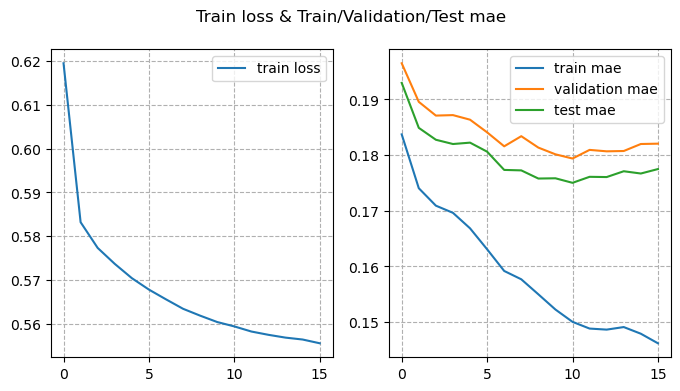

In [15]:
from matplotlib import pyplot as plt
metric_values = np.array(metric_values)
loss_values = [x[1] for x in loss_values]
f, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(loss_values, label="train loss")
ax[0].legend()
ax[0].grid(linestyle="--",which="major")

ax[1].plot(metric_values[:, 1], label="train mae")
ax[1].plot(metric_values[:, 2], label="validation mae")
ax[1].plot(metric_values[:, 3], label="test mae")
ax[1].legend()
ax[1].grid(linestyle="--",which="major")
plt.suptitle("Train loss & Train/Validation/Test mae")
plt.show()